# Heart Rate Estimation

Seismocardiography ([SCG](https://www.ncbi.nlm.nih.gov/pubmed/24111357)) is a very promising technique to measure the Heart Rate (HR) and Respiratory Rate (RR) with a detector positioned above the sternum. It is generally based on accelerometer and gyroscope readings or a combination of them. 

Ballistocardiography ([BCG](https://en.wikipedia.org/wiki/Ballistocardiography)) is an another technique to estimate heart and respiratory rate with a combination of both an accelerometer and a gyroscope. It is an indirect evaluation of HR and RR since the contact between the device and the body of the subject is not required (e.g., the accelerometer platform can be mounted under the slats of the bed).   
  
MuSe (Multi-Sensor miniaturized, low-power, wireless [IMU](https://en.wikipedia.org/wiki/Inertial_measurement_unit)) is an Inertial Measurement Unit (IMU) provided by [221e](https://www.221e.com). In the context of this project, it allows to record the inertial data necessary for the estimation of SCG and BCG.

The goal of this assignment is to estimate the heart rate of an healthy subject, given the linear acceleration and angular velocity measurements recorded by using the aforementioned MuSe platform.

The study must be performed on two datasets: the first is the compulsory one (`center_sternum.txt`), while the second is left at the discretion of the group, among those made available for the assignment.

*Remember that normal heart rate is around [40-100] bpm.*


## Data

The data is provided in `.txt` files. During this study, two healthy subjects were involved with their informed consent. The first dataset was recorded on one subject, while all the other datasets were recorded on the second subject. 

This is the first mandatory file:

* `center_sternum.txt`: MuSe placed on the center of the sternum. The subject was lying supine on his left and right side, respectively. 


Choose one of the following files in order to complete the task.

* `1_Stave_supine_static.txt`: Sensor placed on a bed stave, under the mattress at the level of the chest. The subject was lying supine on his left and right side. 
* `2_Mattress_supine.txt`: Sensor placed on the mattress, near one corner but not under the pillow. The subject laid in the same position as above. 
* `3_Subject_sitting_chair.txt`: Sensor placed on the desk: the subject, sitting on a chair, leaned forearms and hands on the desk. 
* `4_Chest_sweater.txt`: Sensor placed on the subject chest directly on a sweater. 
* `5_Under_chair.txt`: Subject sitting on a chair, sensor placed under the seat of the chair. 

All `.txt` files have 16 columns, containing: 

* Log Freq stands for the acquisition in Hz (i.e., sampling interval is constant).
* AccX, AccY, AccZ are the measured magnitude of linear acceleration along each axis.
* GyroX, GyroY, GyroZ are the measured magnitude of angular velocity along each axis.
* MagnX, MagnY, MagnZ are the measured magnitude of magnetic field along each axis.
* qw, qi, qj, qk are the quaternion components, representing the spatial orientation of the Muse system.

Each dataset includes, in addition to the data, one file containing the adopted configuration of the MuSe(`config_1.txt` for the first measurement, and in `config_5.txt` for the other measurement).
 


In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

SSSFile = "data/1_Stave_supine_static.txt"
MSFile = "data/2_Mattress_supine.txt"
SSCFile = "data/3_Subject_sitting_chair.txt"
CWFile = "data/4_Chest_sweater.txt"
UCFile = "data/5_Under_chair.txt"
CSFile = "data/center_sternum.txt"

FILES = [SSSFile,MSFile,SSCFile,CWFile,UCFile,CSFile]

CONFIG_1 = "config/config_1.txt"
CONFIG_5 = "config/config_5.txt"

In [107]:
# CONFIG 1
# Date:				13-12-2019
# Device: 		Muse_2128 v2 BC
# Configuration:		500 dps, 2 g, 12 G, 100 g, High Resolution, 200 Hz

# X, Y, Z, offset (if exists)
gyroCalibration_1 = np.array([-2.242224, 2.963463, -0.718397])
accCalibration_1 = np.array(
    [
        [1.000966, -0.002326418, -0.0006995499, -3.929942],
        [-0.002326379, 0.9787045, -0.001540918, -13.74679],
        [-0.0006995811, -0.001540928, 1.00403, 60.67546],
    ]
)
magCalibration_1 = np.array(
    [
        [0.9192851, -0.02325168, 0.003480837, -95.67974],
        [-0.02325175, 0.914876, 0.004257396, -244.9142],
        [0.003481006, 0.004257583, 0.8748001, 17.71132],
    ]
)

# CONFIG 5
# Date:				16/04/2019-17/04/2019
# Device: 		Muse_2168 v2 BC
# Configuration:		4000 dps, 2 g, 12 G, 100 g, High Resolution, 100 Hz

# X, Y, Z, offset (if exists)
gyroCalibration_5 = np.array([-2.804399, 1.793105, 0.3411708])

accCalibration_5 = np.array(
    [
        [1.002982, 9.415505e-05, 0.004346743, 3.602701],
        [9.04459e-05, 1.002731, -0.001444198, -20.96658],
        [0.004346536, -0.001444751, 1.030587, 54.97186],
    ]
)

magCalibration_5 = np.array(
    [
        [1.013437, -0.04728858, -0.001861475, -150.4098],
        [-0.04728862, 1.004832, 0.008222118, 74.62431],
        [-0.001861605, 0.008221965, 0.9439077, 630.9805],
    ]
)

In [108]:
metrics = ["Acc","Gyro","Magn"]
axes = ["X","Y","Z"]

1. Data preparation:

    1.1. Load the txt files and select only the columns you are interested in, in order to do a complete data analysis (e.g. Log Freq, AccX, ... )
    


In [136]:
def createDataFrame(iFile):
    dataFrame = pd.read_csv(iFile, delimiter="\t")
    dataFrame = dataFrame.loc[:, "Timestamp":"MagnZ"]
    return dataFrame

def setGyroValues(iDataFrame,iGyroValues):
    gyroCols = np.array(["Gyro"+axe for axe in ["X","Y","Z"]])
    iDataFrame[gyroCols] *= iGyroValues
    return iDataFrame

def setValues(iDataFrame,iValues,iCol):
    valuesCols = np.array([iCol+axe for axe in ["X","Y","Z"]])
    setting = iValues[:,:3]
    offset = iValues[:,3]
    # iDataFrame[accCols] = setting.dot(iDataFrame[accCols])+offset # Doesn't work, need to fix this instead of to use for loop
    for index in range(len(iDataFrame)): # temp, TODO: change
        iDataFrame.loc[index,valuesCols] = setting.dot(iDataFrame.loc[index,valuesCols]) + offset
    return(iDataFrame)

dataFrame = createDataFrame(CSFile)
print(dataFrame.head())
dataFrame = setGyroValues(dataFrame,gyroCalibration_1)
dataFrame = setValues(dataFrame,accCalibration_1,"Acc")
dataFrame = setValues(dataFrame,magCalibration_1,"Magn")


    Timestamp     AccX     AccY    AccZ      GyroX      GyroY     GyroZ  \
0  1576222772  947.086  435.662  70.638  -6.824428 -14.244280  1.404580   
1  1576222772  969.168  387.777  88.877   6.183206 -12.290080 -7.969466   
2  1576222772  989.603  380.335  78.751  11.709920  -4.961832 -7.450382   
3  1576222772  954.894  418.033  88.328  17.877860   2.519084 -5.984733   
4  1576222772  972.096  427.732  99.857  25.221370   5.404580  4.015267   

   MagnX  MagnY  MagnZ  
0   -454   -490   -178  
1   -454   -490   -177  
2   -454   -490   -177  
3   -454   -492   -176  
4   -454   -492   -176  


/var/folders/w4/_vydjkkn59zfdpb44gxcpp9w0000gn/T/ipykernel_96690/589031068.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-502.26144118599996' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  iDataFrame.loc[index,valuesCols] = setting.dot(iDataFrame.loc[index,valuesCols]) + offset
/var/folders/w4/_vydjkkn59zfdpb44gxcpp9w0000gn/T/ipykernel_96690/589031068.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-683.404961988' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  iDataFrame.loc[index,valuesCols] = setting.dot(iDataFrame.loc[index,valuesCols]) + offset
/var/folders/w4/_vydjkkn59zfdpb44gxcpp9w0000gn/T/ipykernel_96690/589031068.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-141.

1. Data preparation:

    1.2. Plot selected data as a function of time and choose a proper time window over which to perform the analysis. Pay attention on the time representation and the measurement unit.

In [140]:
def ticks(value, _):
    if (value >= 0) & (value < len(dataFrame)):
        ticks = datetime.fromtimestamp(
            dataFrame["Timestamp"][value]
        ) - datetime.fromtimestamp(dataFrame["Timestamp"][0])
        return ticks


def graphDataFrame(iDataFrame,iTitle):
    values = np.arange(iDataFrame["Timestamp"].index.min(), iDataFrame["Timestamp"].index.max()+1, 1)

    figure, axs = plt.subplots(3, figsize=(30, 30))
    figure.suptitle(str(iTitle))

    for index, metric in enumerate(metrics):
        metricAxe = np.array([metric + axe for axe in axes])
        axs[index].plot(values, iDataFrame[metricAxe], label=metricAxe)
        axs[index].legend()
        axs[index].xaxis.set_major_formatter(plt.FuncFormatter(ticks))


# graphDataFrame(dataFrame,"Center spectrum")

We can observe some parasit noises in the beginning and the end of each signal.\
Following graphes are the clean parts.\
Values are between 1500 and 14000, which corresponds a few before 11 sec and a few before 1:08 min.

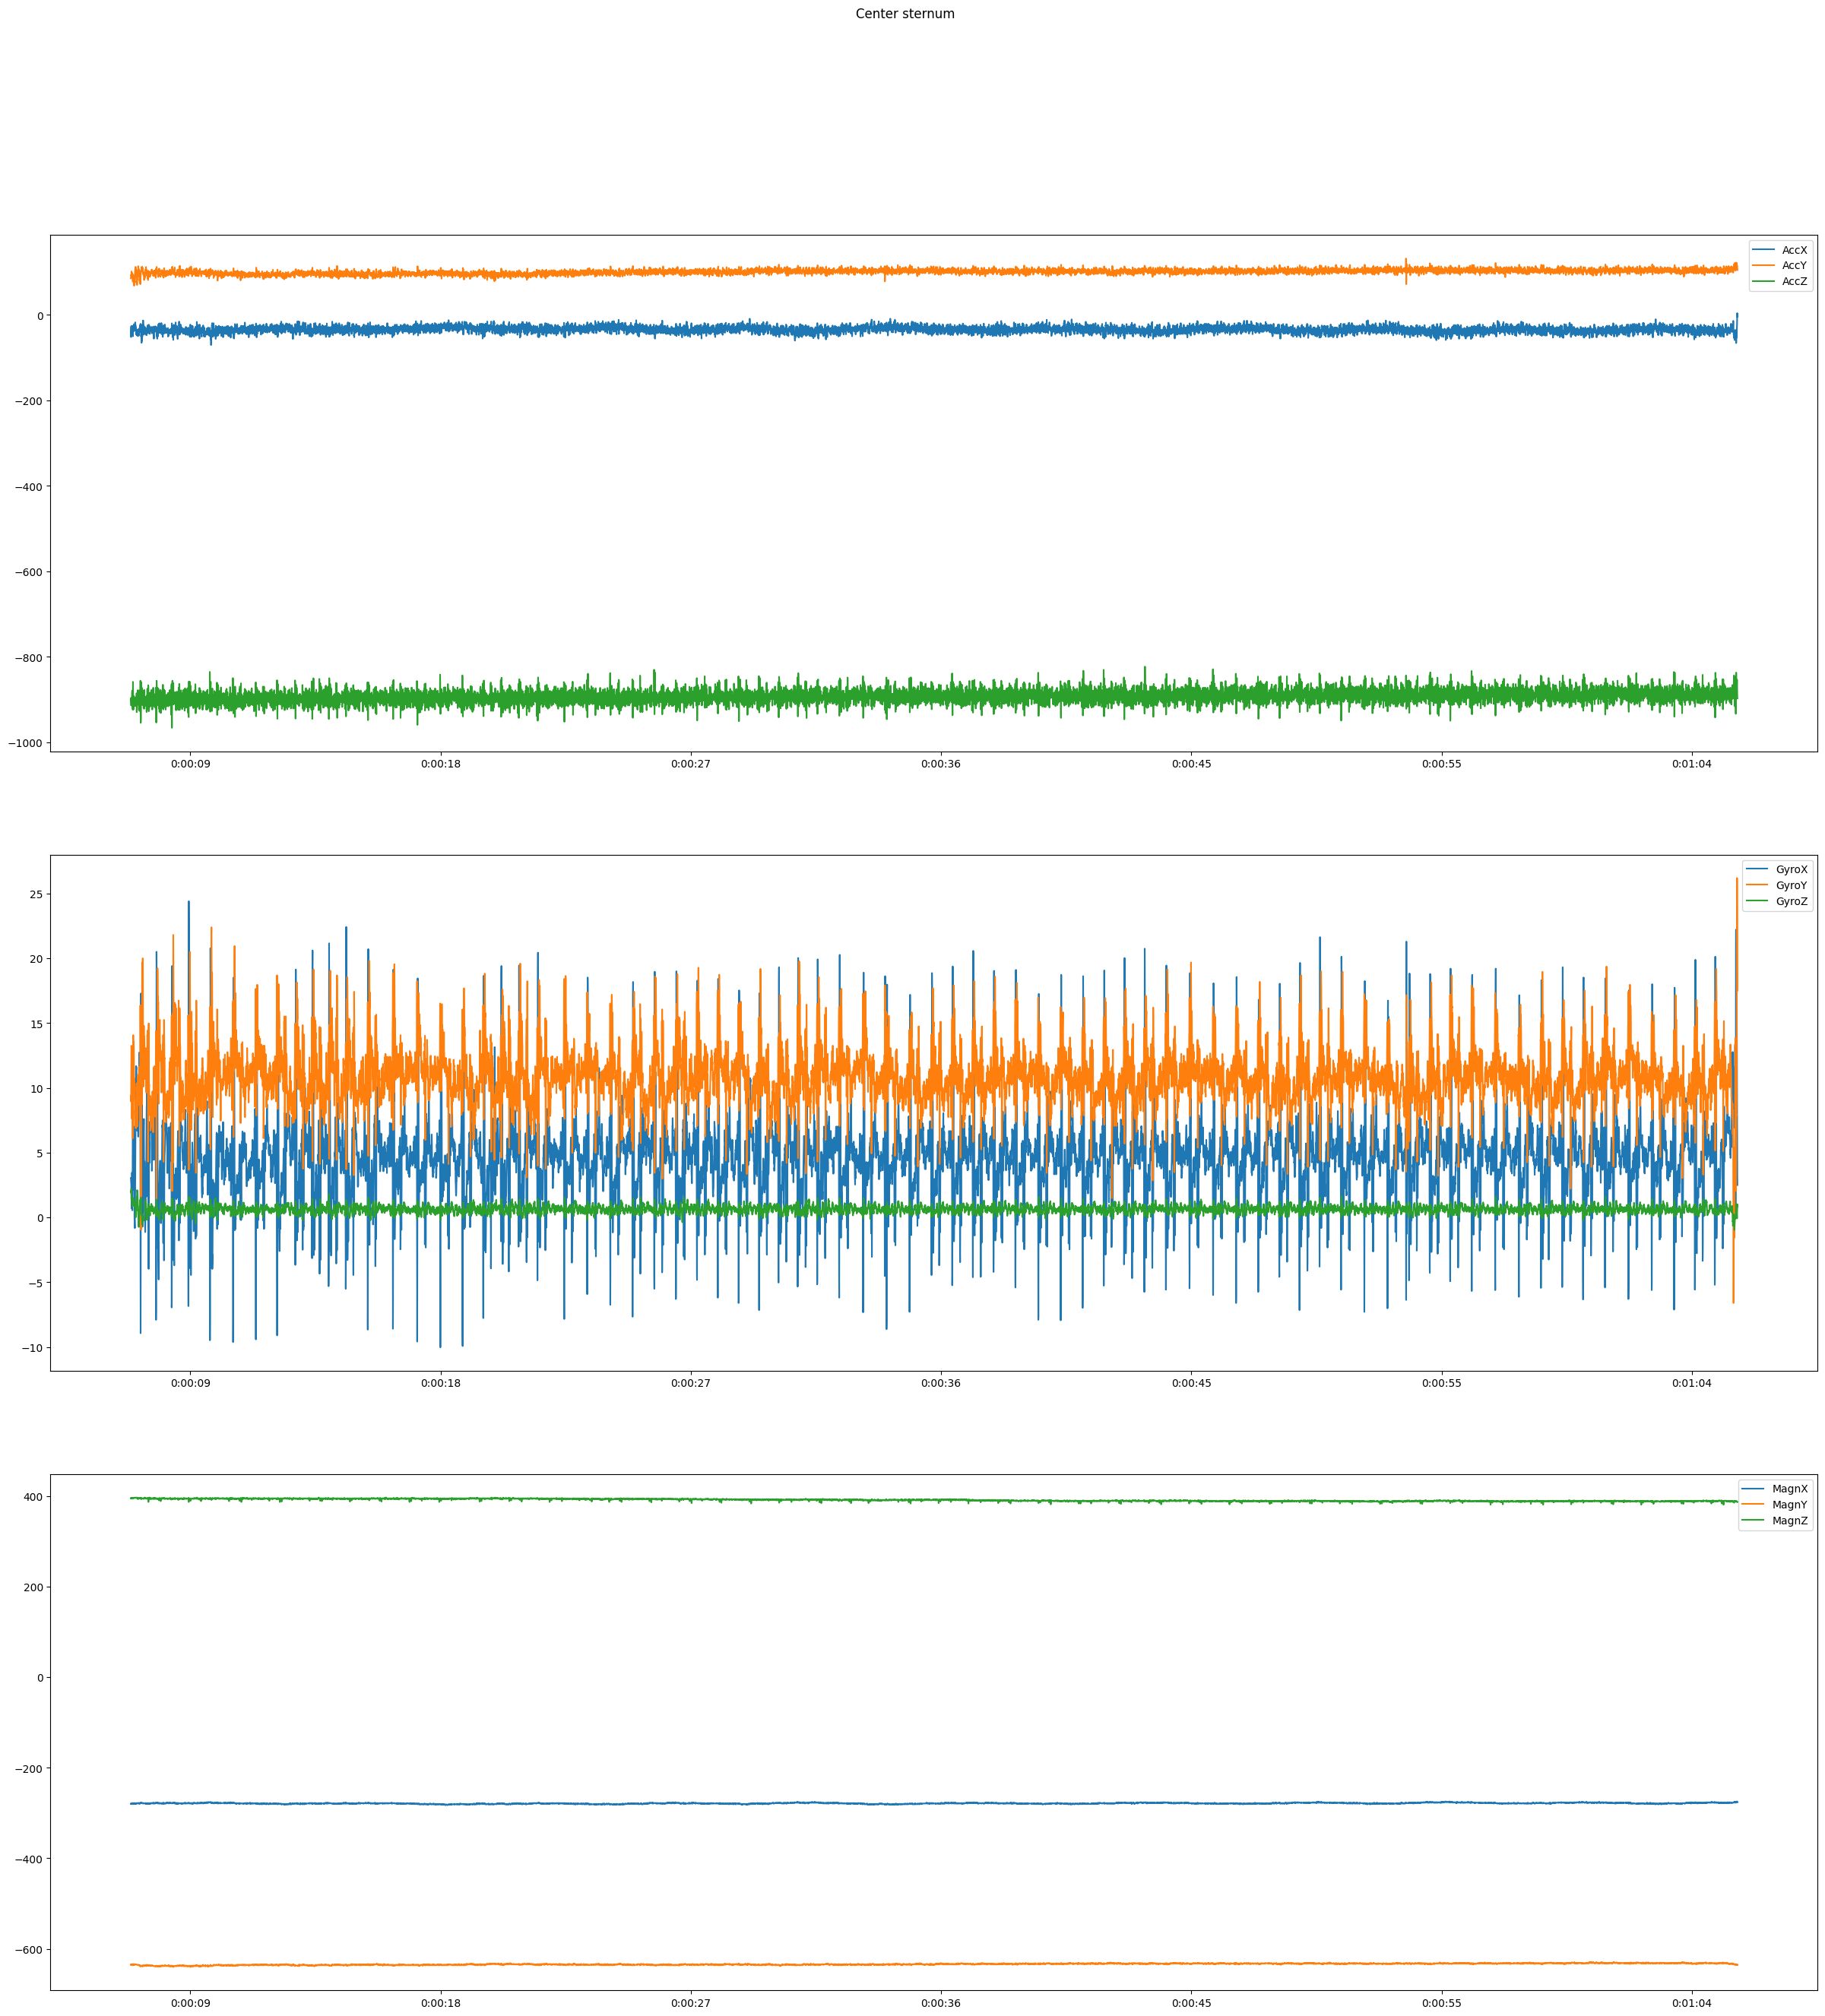

In [142]:
# print(dataFrame)
dataFrameCopy = dataFrame.copy()
tempMin = dataFrameCopy["Timestamp"].iloc[1400]
tempMax = dataFrameCopy["Timestamp"].iloc[14500]
dataFrameCopy = dataFrameCopy[(dataFrameCopy["Timestamp"]>tempMin)&(dataFrameCopy["Timestamp"]<tempMax)]
graphDataFrame(dataFrameCopy, "Center sternum, clean data")


1. Data preparation:

    1.3. In order to do a proper job, decide whether to consider some particular axis or some combination of them as well as derived features for the next step of the task. Motivate your choice.


    
2. Time and frequency analysis:

    2.1. Statistical analysis: provide a statistical description of the chosen dataset. Statistical descriptors includes for example mean, median, variance, standard deviation, 25th and 75th percentiles, and correlation coefficients. Investigate what could be the most interesting descriptors for this type of data, motivating the choices.
    
    2.2. Fourier Analysis: Perform a frequency analysis of the data. Look at the spectrum and explain what you see. Use the Fourier analysis to properly design the filters in the following step. 





3. Filter:
    
    Implement your own filter, trying to extrapolate the heart rate signal. Hints:
    
    (a) Directly from Fourier Analysis, look for the most interesting frequency band.
    
    (b) Choose the appropriate Lowpass/Bandpass/Highpass filter.
        
    (c) Explore another methods by yourselves.
    
    Remember to always motivate your choice.
    
    


4. Metrics:

    4.1. Heart Beat Per Minute (BPM): extrapolate BPM, make an histogram of the result. Does it follow a particular distribution? 
    
    4.2. Heart Rate Variability (HRV): extrapolate HRV, explain why this parameter is important, and plot the results.




5. **Optional**: Elaborate a simple algorithm to extrapolate the heart rate even when the filter fails (e.g. look for a particular threshold...).  





6. Conclusion: 

    Summarise the obtained results, and specifically make a comparison between the two files analysed. Highlight the limitations and the critical issues encountered during the work, motivating the most relevant contribution given by your solution.